# Modeling with Clustered Data

In [1]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

import os.path
from os import path

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import re

from preprocessing_permits import permits_preprocessing_mother_function

import preprocessing_permits as pr

# Clustering

In [2]:
df = permits_preprocessing_mother_function()

In [3]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value = pr.create_clusters(df)
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")

Our DataFrame contains 2,860 observations and 22 features.


In [4]:
import explore as ex

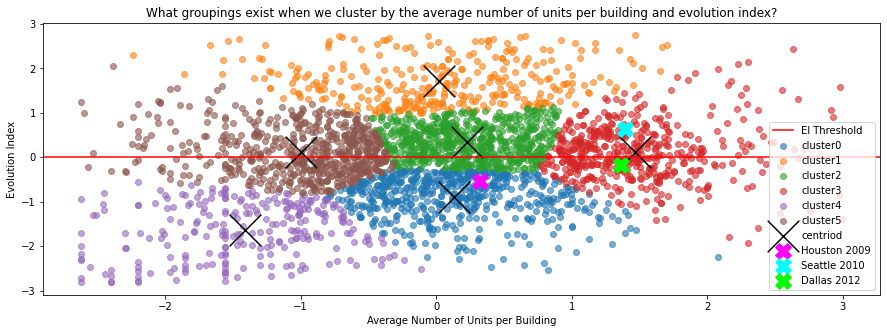

In [5]:
plt.figure(figsize=(15,5))
ex.visualize_clusters(df, centroids, scaled_ei_threshold_value)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 1 to 2989
Data columns (total 22 columns):
city                                       2860 non-null object
state                                      2860 non-null object
year                                       2860 non-null int64
total_high_density_bldgs                   2860 non-null float64
total_high_density_units                   2860 non-null float64
total_high_density_value                   2860 non-null float64
avg_units_per_bldg                         2860 non-null float64
value_per_bldg                             2860 non-null float64
value_per_unit                             2860 non-null float64
city_state_high_density_bldgs_delta_pct    2860 non-null float64
city_state_high_density_units_delta_pct    2860 non-null float64
city_state_high_density_value_delta_pct    2860 non-null float64
market_volume                              2860 non-null float64
market_volume_delta_pct                    2860 non-

In [7]:
# How many observation per cluster?

df.groupby("cluster").city.count().sort_values()

cluster
4    254
1    323
3    486
0    561
5    591
2    645
Name: city, dtype: int64

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

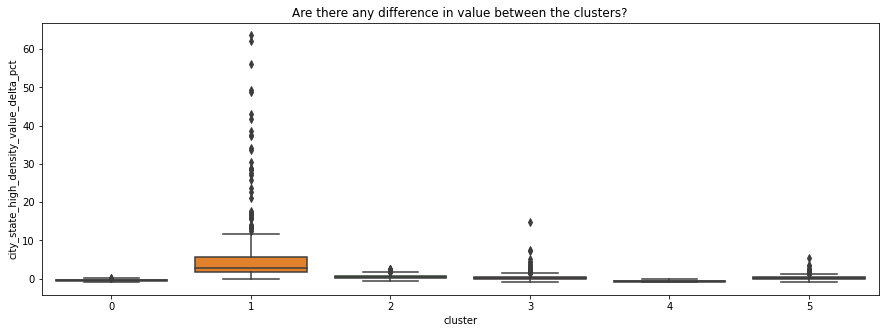

In [8]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="city_state_high_density_value_delta_pct")
plt.title("Are there any difference in value between the clusters?")

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

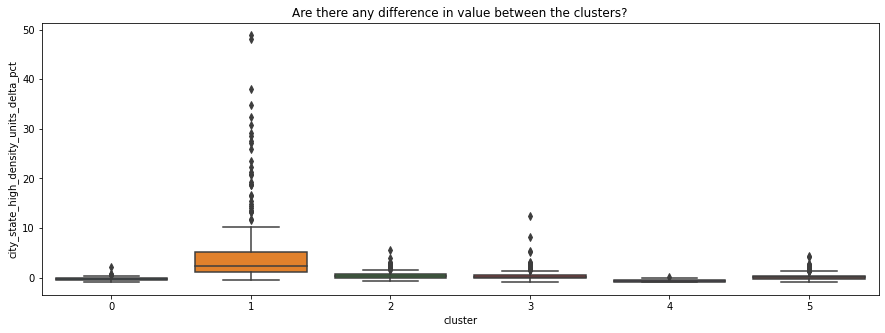

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="city_state_high_density_units_delta_pct")
plt.title("Are there any difference in value between the clusters?")

In [10]:
# df[["avg_units_per_bldg", "ei"]] = scaler.inverse_transform(df[["avg_units_per_bldg", "ei"]])

In [11]:
df[df.ei >= 1].sort_values(by="ei").head(1).index

Int64Index([592], dtype='int64')

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

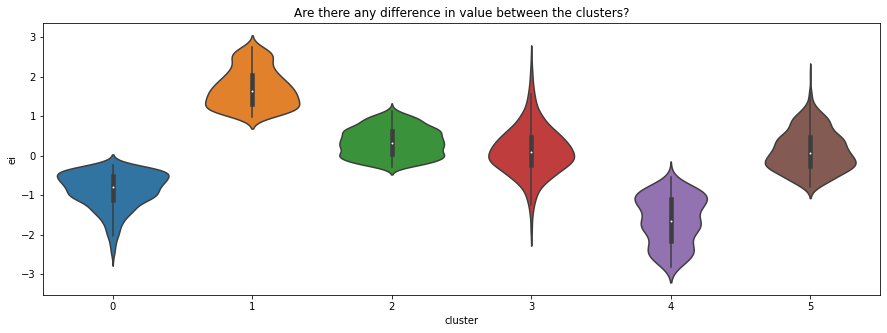

In [12]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, x="cluster", y="ei")
plt.title("Are there any difference in value between the clusters?")

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

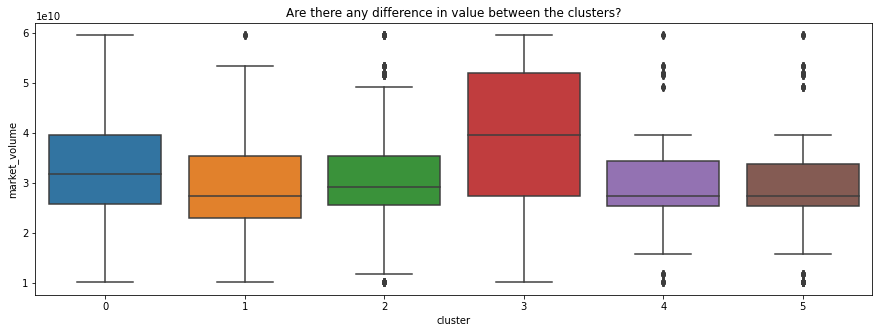

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="market_volume")
plt.title("Are there any difference in value between the clusters?")

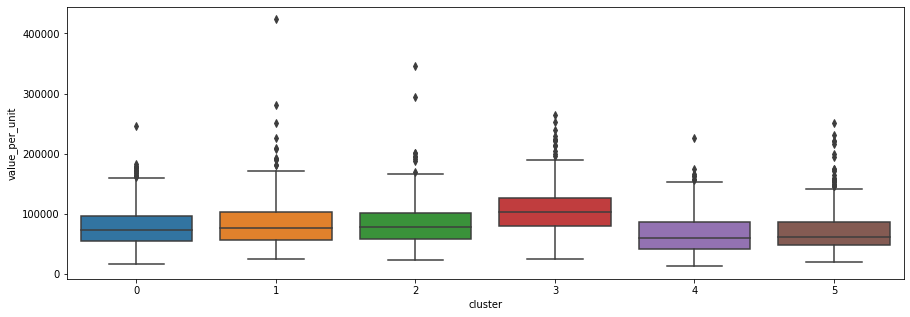

In [14]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="value_per_unit")

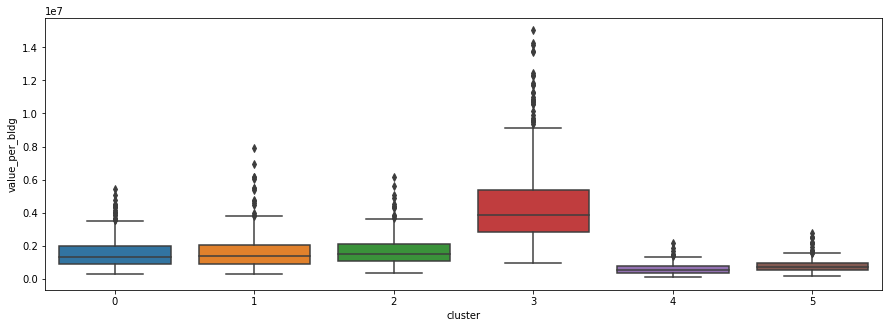

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="value_per_bldg")

In [16]:
df.cluster = "cluster_" + df.cluster.astype(str)

Text(0.5, 1.0, 'Are there are any years that are clustered together?')

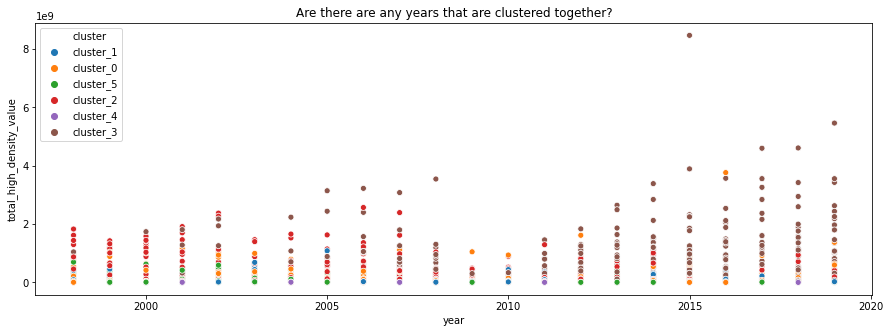

In [17]:
# Are there are any years that are clustered together?
plt.figure(figsize=(15,5))
sns.scatterplot(data=df, x="year", y="total_high_density_value", hue= "cluster")
plt.title("Are there are any years that are clustered together?")

Comments:

* It seems that cluster 3 might have been cities that experienced rapid growth on years that the market was big (meaning that there was a lot of money being invested, in comparison to other observations)

* Cluster 1 might be the smaller cities that are experincing signficantly faster growth than the rest of the market. For example, we might expect a city like Austin (which as recently undergone very rapid expansion to be in cluster 1) because they were smaller to start with, but significant investment has lead them to grow quicker than the market. 

## Exploring individual datapoints

In [18]:
df[df.cluster == "cluster_0"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
1759,Miami,FL,2008,157.0,4196.0,494830000.0,0.840874,3.151783e+06,117928.979981,-0.411985,...,2.566581e+10,-0.239575,-0.746925,Miami_FL,-0.753145,-0.846627,-0.49185,0.050955,False,cluster_0


In [19]:
phoenix = df[df.city == "Phoenix"]
phoenix

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
2048,Phoenix,AZ,1998,722.0,10825.0,5.329850e+08,-0.238240,7.382064e+05,49236.489607,-0.176739,...,2.529787e+10,0.231085,-0.335631,Phoenix_AZ,NaN,NaN,0.176889,0.211911,False,cluster_0
2049,Phoenix,AZ,1999,723.0,8674.0,4.612760e+08,-0.689740,6.380028e+05,53179.156099,0.001385,...,2.609590e+10,0.031545,-0.251392,Phoenix_AZ,-0.175599,-0.157902,0.007787,-0.221300,False,cluster_5
2050,Phoenix,AZ,2000,875.0,10291.0,6.272640e+08,-0.730908,7.168731e+05,60952.677096,0.210235,...,2.742204e+10,0.050818,0.363310,Phoenix_AZ,0.211911,0.176889,-0.302012,-0.429714,False,cluster_5
2051,Phoenix,AZ,2001,563.0,8243.0,4.648680e+08,-0.285431,8.256980e+05,56395.487080,-0.356571,...,2.913103e+10,0.062322,-0.509733,Phoenix_AZ,-0.221300,0.007787,-0.063390,-0.236234,False,cluster_0
2052,Phoenix,AZ,2002,499.0,7343.0,4.378230e+08,-0.275365,8.774008e+05,59624.540379,-0.113677,...,3.169504e+10,0.088016,-0.207108,Phoenix_AZ,-0.429714,-0.302012,-0.056075,-0.036072,False,cluster_2
2053,Phoenix,AZ,2003,430.0,6823.0,4.354000e+08,-0.126501,1.012558e+06,63813.571743,-0.138277,...,2.305050e+10,-0.272741,0.440172,Phoenix_AZ,-0.236234,-0.063390,0.250790,0.048837,False,cluster_2
2054,Phoenix,AZ,2004,481.0,6293.0,4.132720e+08,-0.511983,8.591933e+05,65671.698713,0.118605,...,2.723856e+10,0.181691,-0.312890,Phoenix_AZ,-0.036072,-0.056075,0.765910,-0.108108,False,cluster_5
2055,Phoenix,AZ,2005,451.0,7476.0,5.445940e+08,-0.041187,1.207525e+06,72845.639379,-0.062370,...,3.435308e+10,0.261193,0.060698,Phoenix_AZ,0.048837,0.250790,0.804443,0.274945,False,cluster_2
2056,Phoenix,AZ,2006,429.0,6502.0,7.298010e+08,-0.216812,1.701168e+06,112242.540757,-0.048780,...,3.549408e+10,0.033214,0.366466,Phoenix_AZ,-0.108108,0.765910,-0.388130,-0.578089,False,cluster_2
2057,Phoenix,AZ,2007,575.0,9756.0,9.826890e+08,0.003939,1.709024e+06,100726.629766,0.340326,...,3.375194e+10,-0.049083,0.488532,Phoenix_AZ,0.274945,0.804443,-0.915605,-0.975652,False,cluster_2


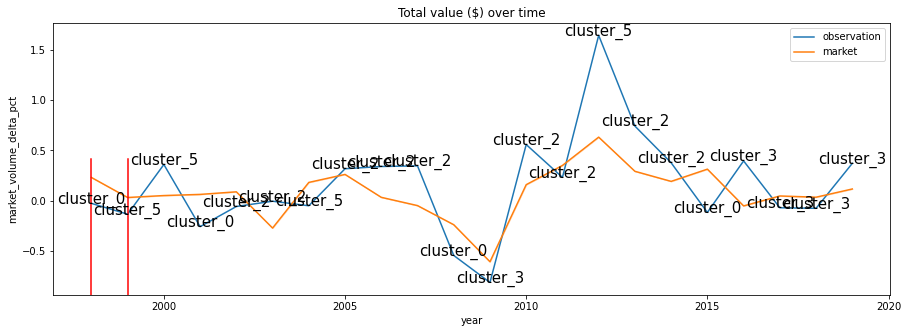

In [20]:
plt.figure(figsize=(15,5))
sns.lineplot(data=phoenix, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        phoenix.year.iloc[i],
        phoenix.city_state_high_density_value_delta_pct.iloc[i],
        f"{phoenix.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
    
plt.axvline(1998, 0,.5, color="r")
plt.axvline(1999, 0,.5, color="r")

Takeways:

1. Cluster_5 is associated with the high peaks.
1. CLuster_0 and Cluster_3 are associasted with the crashes. 
1. Cluster_2 and Cluster_3 are associated with the medium growths. 

Population: 1.2 million (1998), growing (now 1.6 million)

---

In [21]:
df[df.cluster == "cluster_1"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
2494,Santa Cruz,CA,2007,28.0,496.0,89836000.0,0.086912,3.208429e+06,181120.967742,1.153846,...,3.375194e+10,-0.049083,2.204006,Santa Cruz_CA,0.555556,5.63339,-0.985407,-0.964286,False,cluster_1


In [22]:
erie = df[df.city == "Erie"]

In [23]:
erie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 921 to 942
Data columns (total 22 columns):
city                                       22 non-null object
state                                      22 non-null object
year                                       22 non-null int64
total_high_density_bldgs                   22 non-null float64
total_high_density_units                   22 non-null float64
total_high_density_value                   22 non-null float64
avg_units_per_bldg                         22 non-null float64
value_per_bldg                             22 non-null float64
value_per_unit                             22 non-null float64
city_state_high_density_bldgs_delta_pct    22 non-null float64
city_state_high_density_units_delta_pct    22 non-null float64
city_state_high_density_value_delta_pct    22 non-null float64
market_volume                              22 non-null float64
market_volume_delta_pct                    22 non-null float64
ei              

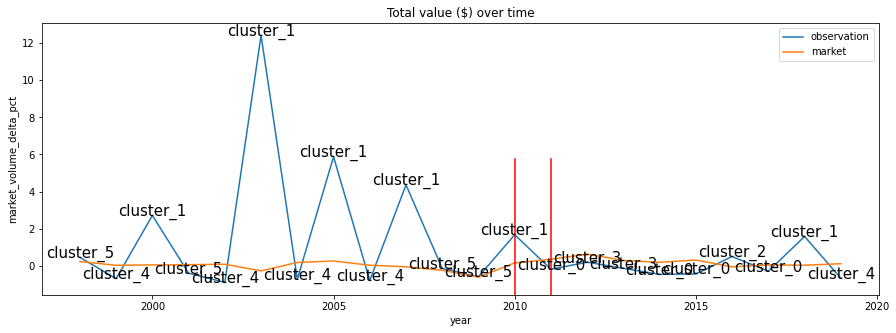

In [24]:
plt.figure(figsize=(15,5))
sns.lineplot(data=erie, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=erie, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        erie.year.iloc[i],
        erie.city_state_high_density_value_delta_pct.iloc[i],
        f"{erie.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2010, 0,.5, color="r")
plt.axvline(2011, 0,.5, color="r")

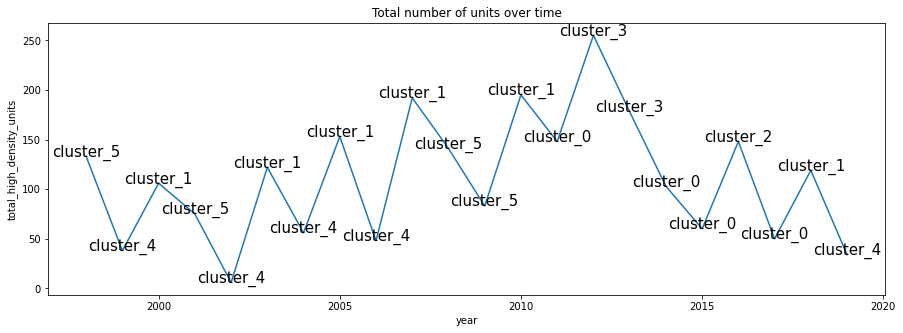

In [25]:
plt.figure(figsize=(15,5))
sns.lineplot(data=erie, x="year",y= "total_high_density_units")
plt.title("Total number of units over time")
for i in range(22):
    plt.text(
        erie.year.iloc[i],
        erie.total_high_density_units.iloc[i],
        f"{erie.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )

Overall, here are the things that I noticed:

1. Cluster_1 is usually associated with the high peaks
1. Cluster_0, Cluster_4 and Cluster_5 are usually associated with the crashes (in this market, these are also associated with the periods just before a spike).
1. Cluster_3 might be associated with higher units built, rather than dollars
1. Cluster_2 might be associated with medium growth

Population: ~ 96,000, with a decline in population since 1990

In [26]:
df[df.cluster == "cluster_2"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
1487,Las Vegas,NV,2012,67.0,1191.0,137915000.0,0.093588,2.058433e+06,115797.649034,0.288462,...,2.569934e+10,0.632549,0.297627,Las Vegas_NV,0.595238,2.10263,0.331349,1.731343,False,cluster_2


In [27]:
spokane = df[df.city == "Spokane"]

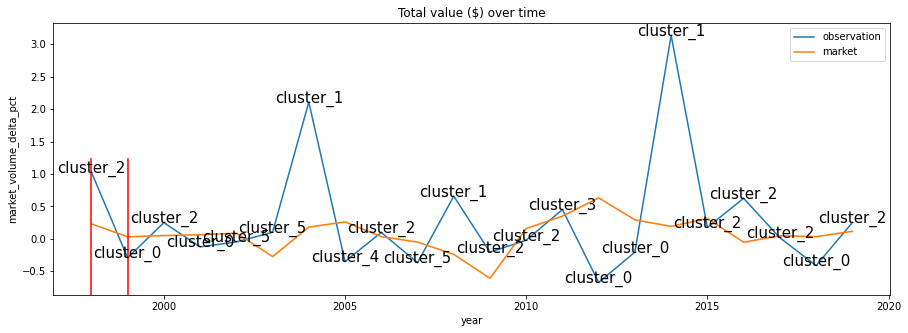

In [28]:
plt.figure(figsize=(15,5))
sns.lineplot(data=spokane, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        spokane.year.iloc[i],
        spokane.city_state_high_density_value_delta_pct.iloc[i],
        f"{spokane.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(1998, 0,.5, color="r")
plt.axvline(1999, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with really high growth
1. Cluster_2 is associated with medium growth
1. Cluster_3 is associated with some growth, ubt only 1 instance
1. Cluster_0, Cluster_4 and Cluster_5 are associated with the low periods

Population: 

185,000 (1998), slight growth

In [29]:
df[df.cluster == "cluster_3"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
2662,Springfield,MO,2014,36.0,969.0,40491000.0,0.853296,1124750.0,41786.377709,0.090909,...,3.958652e+10,0.191969,-0.170662,Springfield_MO,0.44,0.494684,0.167296,-0.444444,False,cluster_3


In [30]:
cs = df[df.city == "Colorado Springs"]

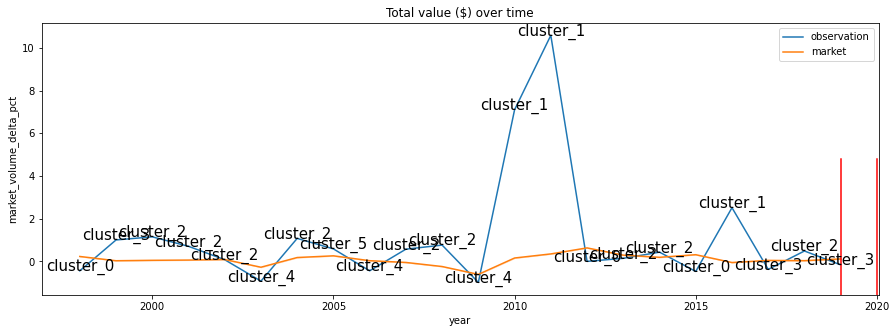

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(data=cs, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        cs.year.iloc[i],
        cs.city_state_high_density_value_delta_pct.iloc[i],
        f"{cs.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2019, 0,.5, color="r")
plt.axvline(2020, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with really high growth
1. Cluster_4, Cluster_0 and Cluster_3 are associated with low poitns
1. Cluster_2 is associated with medium growth

Population: 473,000 and growing

In [32]:
df[df.cluster == "cluster_4"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
635,Clarksville,TN,2011,33.0,334.0,19342000.0,-1.046573,586121.212121,57910.179641,-0.083333,...,1.574184e+10,0.350568,-1.092592,Clarksville_TN,2.3,5.635334,0.229501,0.212121,False,cluster_4


In [33]:
naples = df[df.city == "Naples"]

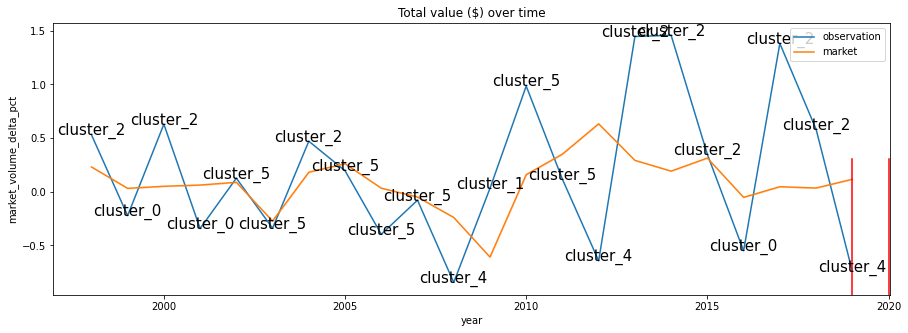

In [34]:
plt.figure(figsize=(15,5))
sns.lineplot(data=naples, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        naples.year.iloc[i],
        naples.city_state_high_density_value_delta_pct.iloc[i],
        f"{naples.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2019, 0,.5, color="r")
plt.axvline(2020, 0,.5, color="r")

Takeaways:

1. Cluster_5 and Cluster_2 are associated with medium to high growth
1. Cluster_0 and Cluster_4 are associated with low points

population: 22,000 and flat

In [35]:
df[df.cluster == "cluster_5"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
1568,Little Rock,AR,2001,50.0,462.0,17248000.0,-1.241889,344960.0,37333.333333,2.125,...,2.913103e+10,0.062322,0.776259,Little Rock_AR,-0.418605,-0.499347,0.241941,-0.32,False,cluster_5


In [36]:
florence = df[df.city == "Florence"]

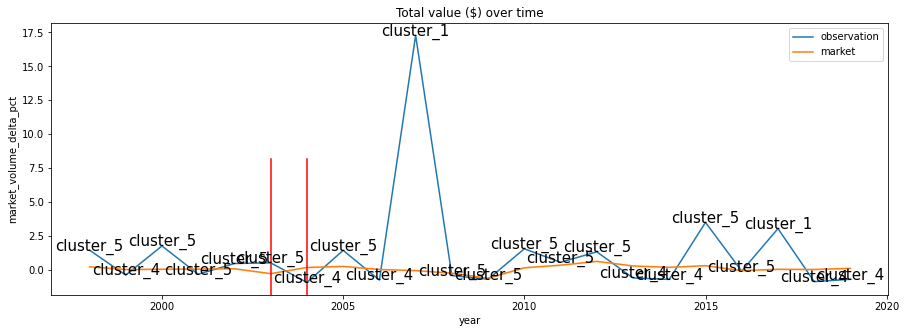

In [37]:
plt.figure(figsize=(15,5))
sns.lineplot(data=florence, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        florence.year.iloc[i],
        florence.city_state_high_density_value_delta_pct.iloc[i],
        f"{florence.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with very large growth
1. Cluster_5 is associated is small growth
1. CLuster_4 is associated with lower growth periods

population: 40,000 and flat

In [38]:
df[df.ei == 0]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster


In [39]:
# assert(1 == 2)

# Label Creation

Current Ideas:

* It seems that the best markets are the ones in cluster_3, however, we need to be able to predict what observations will be in these markets two years before that happens. 
* We know that cluster_0 and cluster_4 are usually the underperforming markets, and usually market will transition from a low to a high. If we can predict those patterns, we can train the model.

In [40]:
df = permits_preprocessing_mother_function()

In [41]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value = pr.create_clusters(df)

In [42]:
df.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,...,2.529787e+10,0.231085,1.200626,Albany_NY,NaN,NaN,-0.702574,-0.468085,False,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,...,2.609590e+10,0.031545,-1.118050,Albany_NY,0.300000,0.370041,0.002124,0.435897,False,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,...,2.742204e+10,0.050818,-0.655825,Albany_NY,-0.468085,-0.702574,0.837198,0.880000,False,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,...,2.913103e+10,0.062322,0.503915,Albany_NY,0.435897,0.002124,0.539167,-0.214286,False,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,...,3.169504e+10,0.088016,0.146820,Albany_NY,0.880000,0.837198,0.825639,0.297872,False,5


In [43]:
# df["previous_cluster"] = df.cluster.shift(-2)

In [44]:
# df["future_cluster"] = df.cluster.shift(-2)

In [45]:
df["test_future_cluster"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["cluster"]]
                                  .shift(-2))

In [46]:
df[["city", "year", "cluster", "test_future_cluster"]].head(50)

,city,year,cluster,test_future_cluster
1,Albany,1998,1,0.0
2,Albany,1999,0,5.0
3,Albany,2000,0,5.0
4,Albany,2001,5,5.0
5,Albany,2002,5,5.0
6,Albany,2003,5,5.0
7,Albany,2004,5,0.0
8,Albany,2005,5,2.0
9,Albany,2006,0,2.0
10,Albany,2007,2,4.0


In [47]:
df[df.city == "Austin"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster
139,Austin,TX,1998,289.0,5128.0,1.788780e+08,0.090118,6.189550e+05,34882.605304,0.066421,...,0.231085,-0.389756,Austin_TX,NaN,NaN,0.847371,0.833910,False,0,2.0
140,Austin,TX,1999,452.0,7849.0,3.191310e+08,0.048674,7.060420e+05,40658.810039,0.564014,...,0.031545,0.758928,Austin_TX,0.667897,0.670240,-0.036750,0.011062,False,2,2.0
141,Austin,TX,2000,530.0,8064.0,3.304540e+08,-0.209140,6.234981e+05,40978.918651,0.172566,...,0.050818,-0.022754,Austin_TX,0.833910,0.847371,-0.351852,-0.501887,False,2,0.0
142,Austin,TX,2001,457.0,8345.0,3.074030e+08,0.144914,6.726543e+05,36836.788496,-0.137736,...,0.062322,-0.190749,Austin_TX,0.011062,-0.036750,-0.556849,-0.743982,False,2,2.0
143,Austin,TX,2002,264.0,5570.0,2.141830e+08,0.415793,8.112992e+05,38452.962298,-0.422319,...,0.088016,-0.627059,Austin_TX,-0.501887,-0.351852,-0.177675,-0.295455,False,0,2.0
144,Austin,TX,2003,117.0,2499.0,1.362260e+08,0.438412,1.164325e+06,54512.204882,-0.556818,...,-0.272741,-0.192562,Austin_TX,-0.743982,-0.556849,1.058197,1.222222,False,2,2.0
145,Austin,TX,2004,186.0,3106.0,1.761280e+08,-0.026901,9.469247e+05,56705.730844,0.589744,...,0.181691,0.126252,Austin_TX,-0.295455,-0.177675,1.792656,0.290323,False,2,3.0
146,Austin,TX,2005,260.0,5261.0,2.803800e+08,0.338272,1.078385e+06,53294.050561,0.397849,...,0.261193,0.328360,Austin_TX,1.222222,1.058197,1.501027,-0.026923,False,2,2.0
147,Austin,TX,2006,240.0,7399.0,4.918650e+08,1.086676,2.049438e+06,66477.226652,-0.076923,...,0.033214,0.734511,Austin_TX,0.290323,1.792656,-0.040668,-0.483333,False,3,3.0
148,Austin,TX,2007,253.0,6902.0,7.012380e+08,0.876725,2.771692e+06,101599.246595,0.054167,...,-0.049083,0.566971,Austin_TX,-0.026923,1.501027,-0.752707,-0.735178,False,2,3.0


In [48]:
df_potential = df[((df.test_future_cluster == 3) | (df.test_future_cluster == 1)) & ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 2))]

In [49]:
df_potential.city.value_counts()

Springfield    7
Birmingham     6
Bismarck       6
New Orleans    6
New York       6
              ..
Riverside      1
Fresno         1
Allentown      1
Brownsville    1
Hartford       1
Name: city, Length: 121, dtype: int64

In [50]:
df_potential

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster
12,Albany,NY,2009,17.0,180.0,7461000.0,-0.950904,4.388824e+05,41450.000000,-0.433333,...,-0.608193,-1.778978,Albany_NY,-0.760563,-0.923942,10.349283,3.176471,True,4,1.0
16,Albany,NY,2013,57.0,683.0,66173000.0,-0.692289,1.160930e+06,96885.797950,-0.337209,...,0.292291,-0.955517,Albany_NY,-0.197183,-0.218525,2.979538,1.491228,True,0,1.0
19,Albany,NY,2016,70.0,1120.0,113414000.0,-0.110207,1.620200e+06,101262.500000,-0.507042,...,-0.052294,-1.072188,Albany_NY,0.000000,0.322473,0.894087,-0.314286,False,0,1.0
30,Albuquerque,NM,2004,16.0,324.0,15510000.0,0.339687,9.693750e+05,47870.370370,-0.515152,...,0.181691,-0.864080,Albuquerque_NM,-0.764706,-0.663046,2.890974,1.500000,True,0,1.0
31,Albuquerque,NM,2005,10.0,273.0,13852000.0,0.877961,1.385200e+06,50739.926740,-0.375000,...,0.261193,-0.489042,Albuquerque_NM,-0.696970,-0.434520,2.315767,1.300000,False,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,Wilmington,NC,2014,24.0,823.0,63833000.0,1.264537,2.659708e+06,77561.360875,0.263158,...,0.191969,-1.035359,Wilmington_NC,-0.538462,-0.423541,0.730954,0.625000,False,0,1.0
2954,Worcester,MA,2007,5.0,71.0,2975000.0,-0.346558,5.950000e+05,41901.408451,-0.705882,...,-0.049083,-2.251914,Worcester_MA,-0.545455,-0.823641,6.772101,2.000000,True,4,1.0
2958,Worcester,MA,2011,2.0,48.0,6740000.0,0.650262,3.370000e+06,140416.666667,-0.777778,...,0.350568,-1.776579,Worcester_MA,-0.866667,-0.708503,-0.252226,0.500000,False,0,3.0
2961,Worcester,MA,2014,3.0,58.0,4637000.0,0.252978,1.545667e+06,79948.275862,0.000000,...,0.191969,-0.368903,Worcester_MA,-0.571429,-0.434857,4.495579,1.666667,True,0,3.0


In [51]:
df_potential[df_potential.city == "Atlanta"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster
118,Atlanta,GA,2000,699.0,16820.0,890199000.0,0.654958,1.273532e+06,52925.029727,0.465409,...,0.050818,0.407363,Atlanta_GA,0.275547,0.685389,0.008036,-0.240343,False,2,3.0
119,Atlanta,GA,2001,660.0,16361.0,963297000.0,0.708091,1.459541e+06,58877.635841,-0.055794,...,0.062322,0.024497,Atlanta_GA,0.383648,0.518656,-0.343811,-0.542424,False,2,3.0
127,Atlanta,GA,2009,36.0,994.0,105936000.0,0.897666,2.942667e+06,106575.452716,-0.777778,...,-0.608193,-1.232511,Atlanta_GA,-0.902439,-0.913938,0.907151,1.305556,False,0,3.0
128,Atlanta,GA,2010,62.0,1101.0,94521000.0,0.091641,1.524532e+06,85850.136240,0.722222,...,0.159076,-0.372677,Atlanta_GA,-0.617284,-0.861064,4.499656,1.548387,True,0,3.0


In [52]:
atlanta = df[df.city == "Atlanta"]

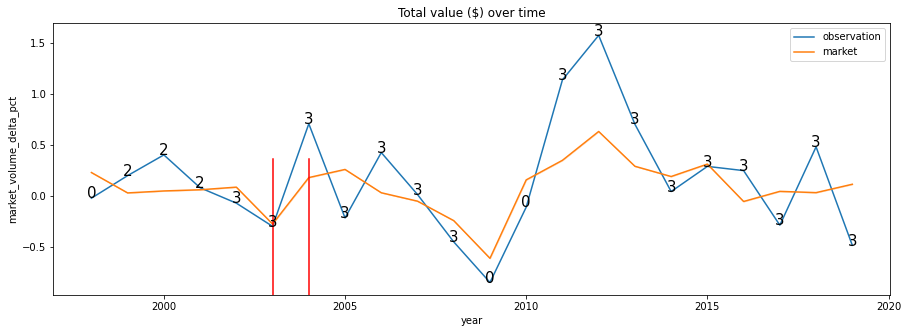

In [53]:
plt.figure(figsize=(15,5))
sns.lineplot(data=atlanta, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        atlanta.year.iloc[i],
        atlanta.city_state_high_density_value_delta_pct.iloc[i],
        f"{atlanta.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

In [54]:
df_potential[df_potential.city == "Dallas"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster
767,Dallas,TX,2005,509.0,9812.0,694394000.0,0.247488,1.364232e+06,70769.873624,0.288608,...,0.261193,0.312789,Dallas_TX,-0.132879,0.117224,0.771893,-0.037328,False,2,3.0
768,Dallas,TX,2006,456.0,11998.0,979997000.0,0.813459,2.149116e+06,81680.030005,-0.104126,...,0.033214,0.438662,Dallas_TX,0.154430,1.221903,0.221789,0.300439,False,2,3.0
771,Dallas,TX,2009,234.0,5933.0,489735000.0,0.748133,2.092885e+06,82544.244059,-0.605396,...,-0.608193,0.059428,Dallas_TX,-0.522449,-0.601968,0.673372,0.512821,False,2,3.0
772,Dallas,TX,2010,203.0,4990.0,479537000.0,0.693067,2.362251e+06,96099.599198,-0.132479,...,0.159076,-0.241644,Dallas_TX,-0.657673,-0.599501,1.472987,1.246305,False,2,3.0


In [55]:
dallas = df[df.city == "Dallas"]

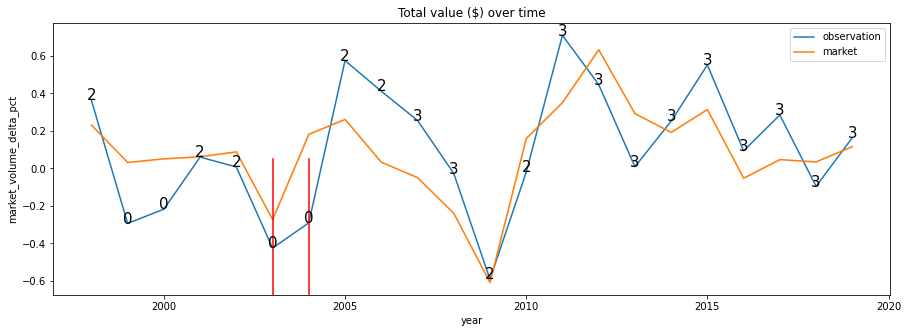

In [56]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dallas, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        dallas.year.iloc[i],
        dallas.city_state_high_density_value_delta_pct.iloc[i],
        f"{dallas.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

In [57]:
df_potential[df_potential.city == "Boston"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster
306,Boston,MA,2004,295.0,6037.0,6.018870e+08,0.359281,2.040295e+06,99699.685274,0.378505,...,0.181691,0.060132,Boston_MA,0.042403,0.355873,0.047765,-0.206780,False,2,3.0
313,Boston,MA,2011,131.0,2321.0,3.257510e+08,0.087266,2.486649e+06,140349.418354,-0.229412,...,0.350568,-0.030429,Boston_MA,-0.015038,0.393778,4.041958,0.404580,True,2,3.0
316,Boston,MA,2014,225.0,6482.0,1.145235e+09,0.971053,5.089933e+06,176679.265659,0.222826,...,0.191969,-0.748717,Boston_MA,0.236264,0.805265,0.179576,0.093333,False,0,3.0


In [58]:
boston = df[df.city == "Boston"]

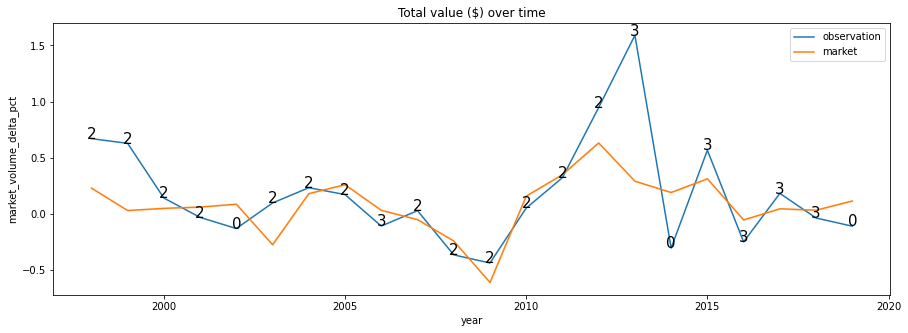

In [59]:
plt.figure(figsize=(15,5))
sns.lineplot(data=boston, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        boston.year.iloc[i],
        boston.city_state_high_density_value_delta_pct.iloc[i],
        f"{boston.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )


In [60]:
centroids

,avg_units_per_bldg,ei
0,0.134099,-0.882271
1,0.023700,1.710680
2,0.231324,0.344536
3,1.465900,0.120773
4,-1.407036,-1.636162
5,-0.995691,0.127961


# Labels

Desired_labels:

    emerging market
    declining market
    stable_high
    stable_low

## Emerging Market

In [61]:
df = permits_preprocessing_mother_function()
df, kmeans, centroids, scaler, scaled_ei_threshold_value = pr.create_clusters(df)

In [62]:
df["test_future_cluster"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["cluster"]]
                                  .shift(-2))

In [63]:
df_emerging = (
    df[((df.test_future_cluster == 3) | (df.test_future_cluster == 1) | (df.test_future_cluster == 5)) 
       & ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 2))]
)

In [64]:
df_emerging["new_label"] = "emerging_market"

In [65]:
df_emerging.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster,new_label
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,...,-1.118050,Albany_NY,0.300000,0.370041,0.002124,0.435897,False,0,5.0,emerging_market
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,...,-0.655825,Albany_NY,-0.468085,-0.702574,0.837198,0.880000,False,0,5.0,emerging_market
11,Albany,NY,2008,30.0,618.0,81793000.0,0.371543,2.726433e+06,132351.132686,-0.577465,...,0.129342,Albany_NY,-0.117647,0.568478,-0.799090,-0.200000,False,2,5.0,emerging_market
12,Albany,NY,2009,17.0,180.0,7461000.0,-0.950904,4.388824e+05,41450.000000,-0.433333,...,-1.778978,Albany_NY,-0.760563,-0.923942,10.349283,3.176471,True,4,1.0,emerging_market
16,Albany,NY,2013,57.0,683.0,66173000.0,-0.692289,1.160930e+06,96885.797950,-0.337209,...,-0.955517,Albany_NY,-0.197183,-0.218525,2.979538,1.491228,True,0,1.0,emerging_market


## Declining Market

In [66]:
df_declining = (
    df[((df.test_future_cluster == 4) | (df.test_future_cluster == 0) | (df.test_future_cluster == 2)) 
       & ((df.cluster == 1) | (df.cluster == 3) | (df.cluster == 5))]
)

In [67]:
df_declining["new_label"] = "declining_market"

In [68]:
df_declining.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster,new_label
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,...,1.200626,Albany_NY,NaN,NaN,-0.702574,-0.468085,False,1,0.0,declining_market
7,Albany,NY,2004,61.0,614.0,54101000.0,-1.058312,8.869016e+05,88112.377850,0.386364,...,0.271562,Albany_NY,0.297872,0.825639,-0.036099,-0.442623,False,5,0.0,declining_market
8,Albany,NY,2005,113.0,1294.0,104380000.0,-0.786431,9.237168e+05,80664.605873,0.852459,...,0.594437,Albany_NY,1.568182,1.763935,-0.060203,-0.371681,False,5,2.0,declining_market
14,Albany,NY,2011,71.0,768.0,84677000.0,-0.905840,1.192634e+06,110256.510417,1.958333,...,1.659246,Albany_NY,3.176471,10.349283,-0.218525,-0.197183,False,1,0.0,declining_market
17,Albany,NY,2014,70.0,839.0,85759000.0,-0.691727,1.225129e+06,102215.733015,0.228070,...,0.117312,Albany_NY,-0.186047,-0.164346,0.322473,0.000000,False,5,0.0,declining_market


## Stable High

In [69]:
df_stable_high = (
    df[((df.test_future_cluster == 1) | (df.test_future_cluster == 3) | (df.test_future_cluster == 5)) 
       & ((df.cluster == 1) | (df.cluster == 3)) | (df.cluster == 5)]
)

In [70]:
df_stable_high["new_label"] = "stable_high"

In [71]:
df_stable_high.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster,new_label
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,438142.857143,48876.494024,1.240000,...,0.503915,Albany_NY,0.435897,0.002124,0.539167,-0.214286,False,5,5.0,stable_high
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,630510.638298,62387.368421,-0.160714,...,0.146820,Albany_NY,0.880000,0.837198,0.825639,0.297872,False,5,5.0,stable_high
6,Albany,NY,2003,44.0,554.0,37765000.0,-0.590310,858295.454545,68167.870036,-0.063830,...,0.776178,Albany_NY,-0.214286,0.539167,1.763935,1.568182,False,5,5.0,stable_high
7,Albany,NY,2004,61.0,614.0,54101000.0,-1.058312,886901.639344,88112.377850,0.386364,...,0.271562,Albany_NY,0.297872,0.825639,-0.036099,-0.442623,False,5,0.0,stable_high
8,Albany,NY,2005,113.0,1294.0,104380000.0,-0.786431,923716.814159,80664.605873,0.852459,...,0.594437,Albany_NY,1.568182,1.763935,-0.060203,-0.371681,False,5,2.0,stable_high


## Stable Low

In [72]:
df_stable_low = (
    df[
        ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 2)) 
        & ((df.test_future_cluster == 4) | (df.test_future_cluster == 0) | (df.test_future_cluster == 2))
    ]
)

In [73]:
df_stable_low["new_label"] = "stable_low"

In [74]:
df_stable_low.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,cluster,test_future_cluster,new_label
9,Albany,NY,2006,34.0,494.0,52148000.0,-0.300710,1.533765e+06,105562.753036,-0.699115,...,-0.995144,Albany_NY,-0.442623,-0.036099,0.568478,-0.117647,False,0,2.0,stable_low
10,Albany,NY,2007,71.0,981.0,98096000.0,-0.401502,1.381634e+06,99995.922528,1.088235,...,0.932790,Albany_NY,-0.371681,-0.060203,-0.923942,-0.760563,False,2,4.0,stable_low
20,Albany,NY,2017,62.0,925.0,96431000.0,-0.248016,1.555339e+06,104249.729730,-0.114286,...,-0.297136,Albany_NY,-0.563380,-0.633813,-0.373065,-0.225806,False,0,0.0,stable_low
24,Albuquerque,NM,1998,13.0,388.0,12679000.0,1.031626,9.753077e+05,32677.835052,-0.745098,...,-2.138464,Albuquerque_NM,NaN,NaN,-0.749586,-0.769231,False,0,0.0,stable_low
26,Albuquerque,NM,2000,3.0,70.0,3175000.0,0.599576,1.058333e+06,45357.142857,-0.880000,...,-1.714803,Albuquerque_NM,-0.769231,-0.749586,13.497638,21.666667,True,0,2.0,stable_low


In [75]:
df["new_label"] = np.nan

In [76]:
df.new_label = df.new_label.fillna(df_stable_low.new_label)

In [77]:
df.new_label = df.new_label.fillna(df_stable_high.new_label)

In [78]:
df.new_label = df.new_label.fillna(df_declining.new_label)

In [79]:
df.new_label = df.new_label.fillna(df_emerging.new_label)

In [80]:
df.new_label.value_counts(dropna=False)

stable_high         999
stable_low          776
emerging_market     574
declining_market    279
NaN                 232
Name: new_label, dtype: int64

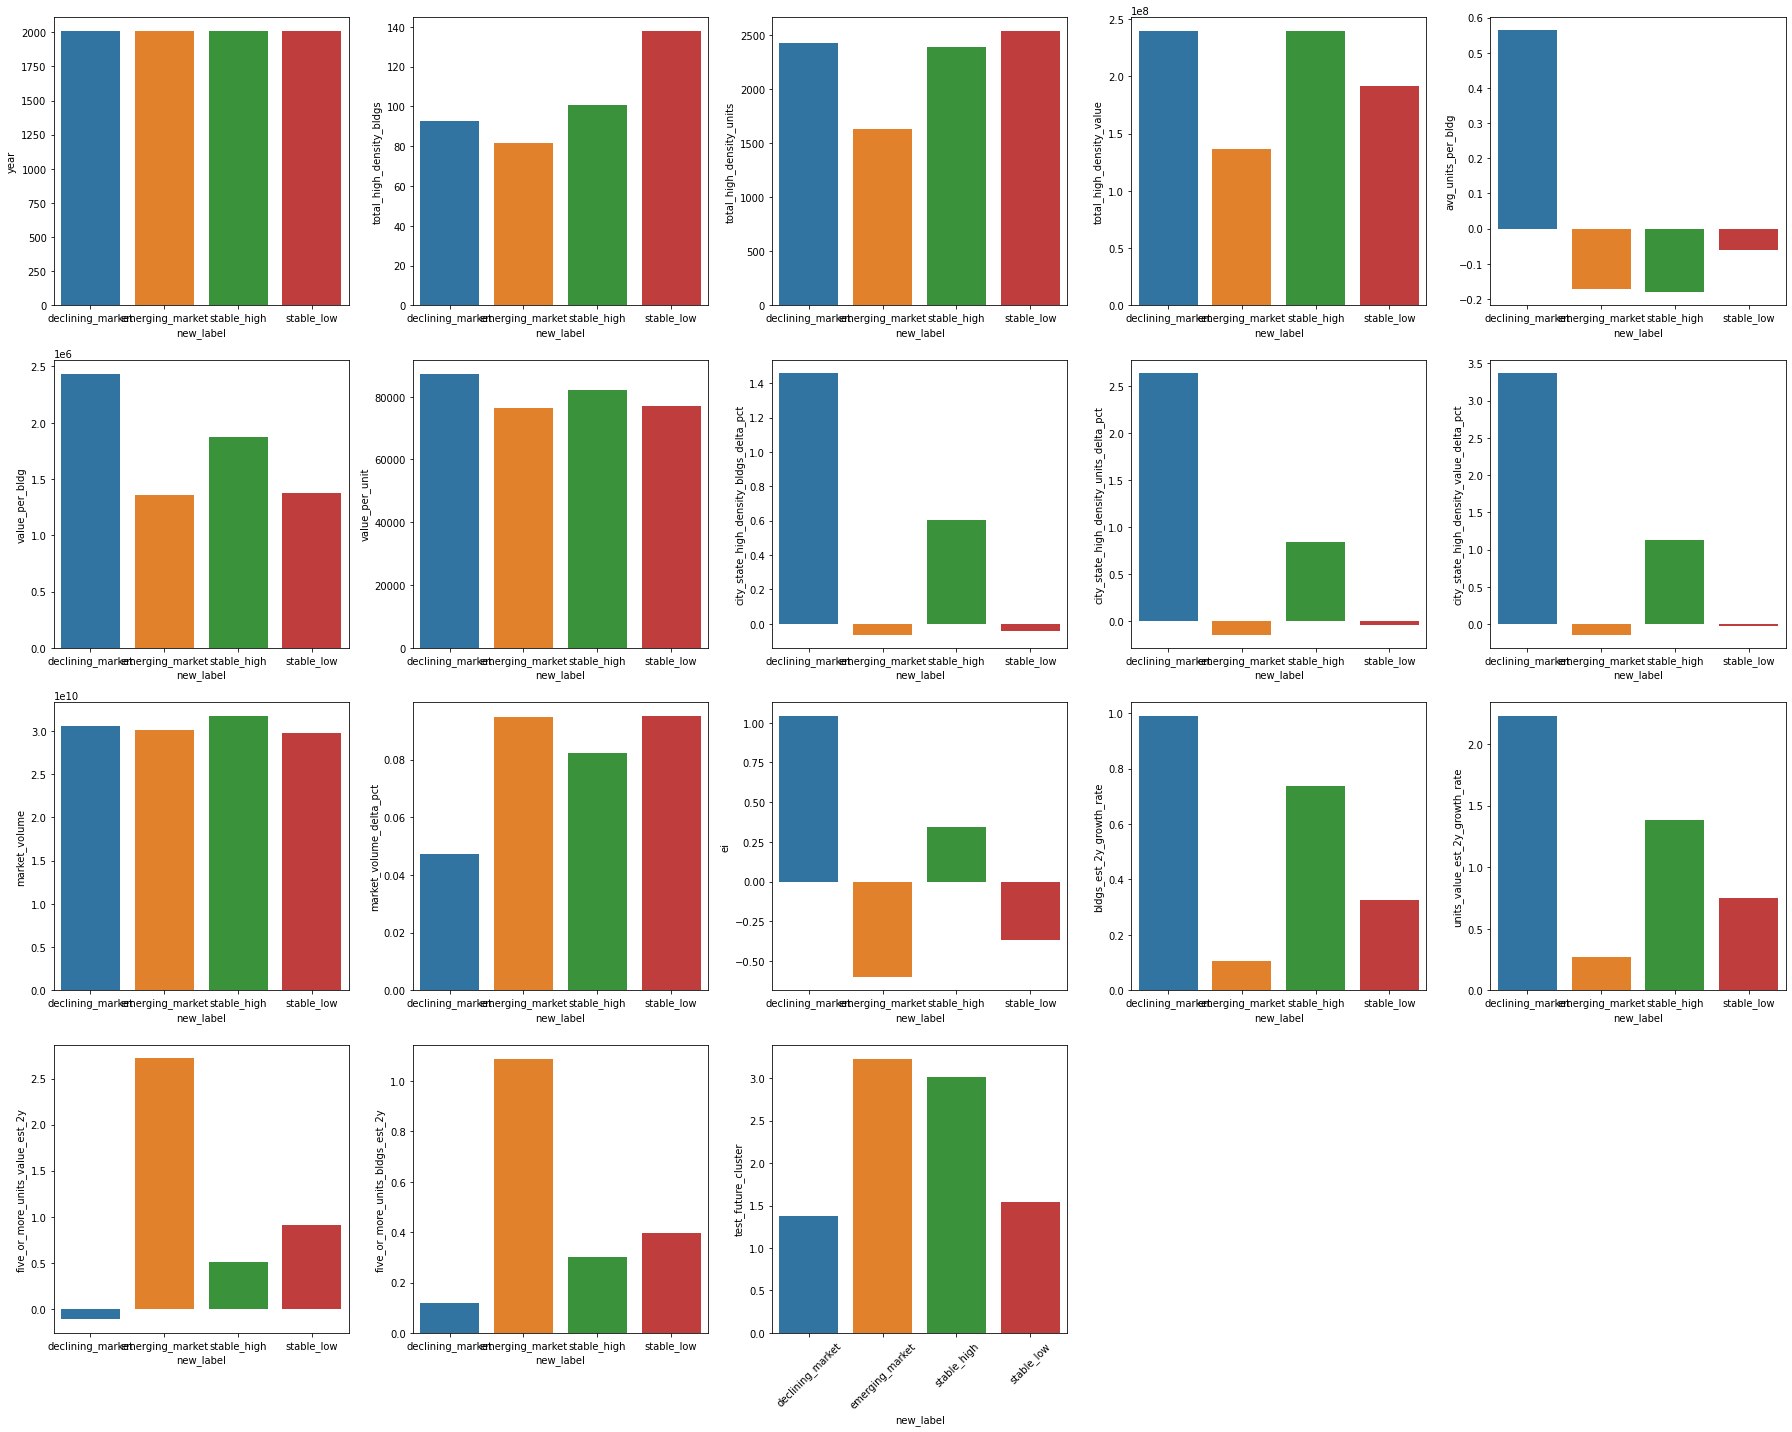

In [81]:
f = plt.figure(figsize=(25,20))
continuous_data = df.select_dtypes(include=["int", "float"])

for count, element in enumerate(continuous_data):
    f.add_subplot(4,5, count+1)
    sns.barplot(data=df, x="new_label", y=element, ci=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 1 to 2989
Data columns (total 24 columns):
city                                       2860 non-null object
state                                      2860 non-null object
year                                       2860 non-null int64
total_high_density_bldgs                   2860 non-null float64
total_high_density_units                   2860 non-null float64
total_high_density_value                   2860 non-null float64
avg_units_per_bldg                         2860 non-null float64
value_per_bldg                             2860 non-null float64
value_per_unit                             2860 non-null float64
city_state_high_density_bldgs_delta_pct    2860 non-null float64
city_state_high_density_units_delta_pct    2860 non-null float64
city_state_high_density_value_delta_pct    2860 non-null float64
market_volume                              2860 non-null float64
market_volume_delta_pct                    2860 non-

# Modeling Phase II

In [83]:
def split_data(df, label_feature, train_size=.75,random_state = 124):
    train, test = train_test_split(df, train_size=train_size, random_state=random_state, stratify = df[label_feature])
    train, validate = train_test_split(train, train_size=train_size, random_state=random_state, stratify = train[label_feature])
    return train, validate, test

def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

def prep_data_for_modeling_permits(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 1997]
    


    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]

    features_for_modeling += [label_feature]

    data = df_model[features_for_modeling].set_index("observation_id")
    
    train, validate, test = split_data(data, label_feature)
    train = train.sort_values("observation_id")
    validate = validate.sort_values("observation_id")
    test = test.sort_values("observation_id")
    
    
    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_validate = validate.drop(columns=label_feature)
    y_validate = validate[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]
    
    scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

    return train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test

In [84]:
df = permits_preprocessing_mother_function()
df, kmeans, centroids, scaler, scaled_ei_threshold_value = pr.create_clusters(df)

In [85]:
df["new_label"] = np.nan

df.new_label = df.new_label.fillna(df_stable_low.new_label)

df.new_label = df.new_label.fillna(df_stable_high.new_label)

df.new_label = df.new_label.fillna(df_declining.new_label)

df.new_label = df.new_label.fillna(df_emerging.new_label)

In [86]:
df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

In [87]:
df = df[df.year < 2018]

In [88]:
df.new_label.value_counts()

stable_high         971
stable_low          776
emerging_market     574
declining_market    279
Name: new_label, dtype: int64

In [89]:
# df = df.append(df[df.new_label])
# df = df.append(df[df.new_label])

In [90]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster"]

In [91]:
# features_for_modeling = ["ei", "avg_units_per_bldg"]
label_feature = "new_label"

In [92]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = prep_data_for_modeling_permits(df, features_for_modeling, label_feature)

# Decision Tree

In [93]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [95]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["emerging_market"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.52. validate_score = 0.50, recall = 0.00
Max_depth = 2, accuracy_score = 0.62. validate_score = 0.63, recall = 0.00
Max_depth = 3, accuracy_score = 0.69. validate_score = 0.70, recall = 0.04
Max_depth = 4, accuracy_score = 0.69. validate_score = 0.68, recall = 0.07
Max_depth = 5, accuracy_score = 0.73. validate_score = 0.70, recall = 0.29
Max_depth = 6, accuracy_score = 0.74. validate_score = 0.69, recall = 0.29
Max_depth = 7, accuracy_score = 0.76. validate_score = 0.69, recall = 0.38
Max_depth = 8, accuracy_score = 0.77. validate_score = 0.68, recall = 0.39
Max_depth = 9, accuracy_score = 0.78. validate_score = 0.66, recall = 0.39
Max_depth = 10, accuracy_score = 0.80. validate_score = 0.67, recall = 0.41
Max_depth = 11, accuracy_score = 0.82. validate_score = 0.66, recall = 0.55
Max_depth = 12, accuracy_score = 0.83. validate_score = 0.65, recall = 0.57
Max_depth = 13, accuracy_score = 0.85. validate_score = 0.65, recall = 0.63
Max_depth = 14, accur

In [96]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [97]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.69
                  declining_market  emerging_market  stable_high  stable_low
declining_market                85                4           68           0
emerging_market                  0               22            0         301
stable_high                     62                2          481           1
stable_low                       0                9            0         427


,declining_market,emerging_market,stable_high,stable_low,accuracy,macro avg,weighted avg
precision,0.578231,0.594595,0.876138,0.585734,0.694254,0.658675,0.695341
recall,0.541401,0.068111,0.880952,0.979358,0.694254,0.617456,0.694254
f1-score,0.559211,0.122222,0.878539,0.733047,0.694254,0.573255,0.633765
support,157.000000,323.000000,546.000000,436.000000,0.694254,1462.000000,1462.000000


In [98]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

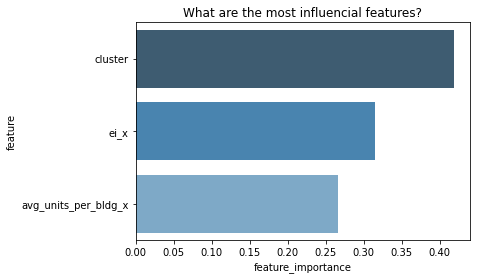

In [99]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. The total `quantity_of_mortgages_pop` doesn't seem to be as influencial in the predictions.

# Random Forest

In [100]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(rf, y_pred, y_train)
    recall_score = report["emerging_market"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.62. validate_score = 0.61, recall = 0.00
Max_depth = 2, accuracy_score = 0.65. validate_score = 0.66, recall = 0.21
Max_depth = 3, accuracy_score = 0.71. validate_score = 0.69, recall = 0.27
Max_depth = 4, accuracy_score = 0.72. validate_score = 0.70, recall = 0.27
Max_depth = 5, accuracy_score = 0.76. validate_score = 0.70, recall = 0.41
Max_depth = 6, accuracy_score = 0.78. validate_score = 0.69, recall = 0.46
Max_depth = 7, accuracy_score = 0.81. validate_score = 0.69, recall = 0.50
Max_depth = 8, accuracy_score = 0.84. validate_score = 0.68, recall = 0.55
Max_depth = 9, accuracy_score = 0.87. validate_score = 0.67, recall = 0.60
Max_depth = 10, accuracy_score = 0.89. validate_score = 0.69, recall = 0.63
Max_depth = 11, accuracy_score = 0.91. validate_score = 0.68, recall = 0.70
Max_depth = 12, accuracy_score = 0.94. validate_score = 0.67, recall = 0.75
Max_depth = 13, accuracy_score = 0.95. validate_score = 0.68, recall = 0.80
Max_depth = 14, accur

In [101]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [102]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.71
                  declining_market  emerging_market  stable_high  stable_low
declining_market                69                0           87           1
emerging_market                  0               86            2         235
stable_high                     36                0          508           2
stable_low                       1               58            7         370


,declining_market,emerging_market,stable_high,stable_low,accuracy,macro avg,weighted avg
precision,0.650943,0.597222,0.841060,0.608553,0.706566,0.674444,0.697434
recall,0.439490,0.266254,0.930403,0.848624,0.706566,0.621193,0.706566
f1-score,0.524715,0.368308,0.883478,0.708812,0.706566,0.621328,0.679046
support,157.000000,323.000000,546.000000,436.000000,0.706566,1462.000000,1462.000000


In [103]:
coef = rf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

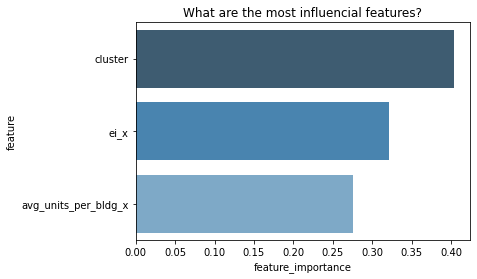

In [104]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, for the random_forest model, the delta of the number of loans approved by city where the most important or influencial indicator of whether a city would be `a hot martket` or not. The evolution index was the second most influencial feature. Again, the total `quantity_of_morgages_pop` was the least influencial feature.

# KNN

In [105]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(knn, y_pred, y_train)
    recall_score = report["emerging_market"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.62, recall = 1.00
Max_depth = 2, accuracy_score = 0.82. validate_score = 0.61, recall = 1.00
Max_depth = 3, accuracy_score = 0.83. validate_score = 0.66, recall = 0.71
Max_depth = 4, accuracy_score = 0.79. validate_score = 0.66, recall = 0.85
Max_depth = 5, accuracy_score = 0.79. validate_score = 0.69, recall = 0.62
Max_depth = 6, accuracy_score = 0.78. validate_score = 0.66, recall = 0.74
Max_depth = 7, accuracy_score = 0.76. validate_score = 0.68, recall = 0.55
Max_depth = 8, accuracy_score = 0.75. validate_score = 0.67, recall = 0.69
Max_depth = 9, accuracy_score = 0.75. validate_score = 0.67, recall = 0.52
Max_depth = 10, accuracy_score = 0.74. validate_score = 0.67, recall = 0.63
Max_depth = 11, accuracy_score = 0.73. validate_score = 0.70, recall = 0.50
Max_depth = 12, accuracy_score = 0.73. validate_score = 0.68, recall = 0.59
Max_depth = 13, accuracy_score = 0.74. validate_score = 0.71, recall = 0.49
Max_depth = 14, accur

In [106]:
knn, y_pred = model.run_knn(train_scaled, y_train, 1)
predictions["knn"] = y_pred

In [107]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 1.00
                  declining_market  emerging_market  stable_high  stable_low
declining_market               157                0            0           0
emerging_market                  0              323            0           0
stable_high                      0                0          546           0
stable_low                       0                0            0         436


,declining_market,emerging_market,stable_high,stable_low,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,157.0,323.0,546.0,436.0,1.0,1462.0,1462.0


In [108]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.37
Decision_Tree = 0.69
Random_Forest = 0.71
Knn = 1.00


In [109]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["emerging_market"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.07
Random_Forest = 0.27
Knn = 1.00


In [110]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["emerging_market"].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.59
Random_Forest = 0.60
Knn = 1.00


## Conclusion:

Overall, we see that because we have optimized for *recall*, the accuracy scores are a bit lower than expected. However, our recall scores are really good. We will choose the KNN model as the most effective model, given that it consistently achieved the best scores (for accuracy, recall and precision). 

Just for reference: 

At 30% oversampling:
* Best Model: KNN, K_n =1 (98% accuracy, 93% recall)
* Accuracy diff between train and test = 12%
* Recall diff between train and test = 0%

At 50% oversampling:
* Best Model: KNN, K_n = 1(100% accuracy, 100% recall)
* Accuracy diff between train and test = 9%
* Recall diff between train and test = 0%

# Evaluate

In [111]:
knn, y_pred = model.run_knn(train_scaled, y_train, 1)

In [112]:
y_pred = knn.predict(test_scaled)

In [113]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.62
                  declining_market  emerging_market  stable_high  stable_low
declining_market                37                0           33           0
emerging_market                  0               61            0          82
stable_high                     42                0          201           0
stable_low                       0               91            0         103


,declining_market,emerging_market,stable_high,stable_low,accuracy,macro avg,weighted avg
precision,0.468354,0.401316,0.858974,0.556757,0.618462,0.571350,0.626022
recall,0.528571,0.426573,0.827160,0.530928,0.618462,0.578308,0.618462
f1-score,0.496644,0.413559,0.842767,0.543536,0.618462,0.574127,0.621758
support,70.000000,143.000000,243.000000,194.000000,0.618462,650.000000,650.000000


----

# Prediction

In [114]:
df = permits_preprocessing_mother_function()

In [115]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,...,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,0.370041,0.300000,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,...,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,-0.702574,-0.468085,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,...,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.300000,0.370041,0.002124,0.435897,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,...,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,-0.468085,-0.702574,0.837198,0.880000,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,...,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,0.435897,0.002124,0.539167,-0.214286,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,...,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.727273,-0.547264,2.203768,4.000000,True
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,...,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,-0.666667,-0.729440,0.379310,-0.333333,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,...,5.515964,5.158824e+10,0.046775,6.224796,York_PA,4.000000,2.203768,1.567229,0.666667,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,...,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.333333,0.379310,NaN,NaN,False


In [116]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

In [117]:
# create object
scaler = PowerTransformer()
# fit object
scaler.fit(df[["avg_units_per_bldg"]])
# transform using object
df["avg_units_per_bldg_scaled"] = scaler.transform(df[["avg_units_per_bldg"]])

scaler.fit(df[["ei"]])
# transform using object
df["ei_scaled"] = scaler.transform(df[["ei"]])

In [118]:
df = df.dropna()

In [119]:
# define features for KMeans modeling
X = df[["avg_units_per_bldg_scaled", "ei_scaled"]]

# cluster using k of 6

# create object
kmeans = KMeans(n_clusters=6, random_state=123)
# fit object
kmeans.fit(X)
# predict using object
df["cluster"] = kmeans.predict(X)

In [120]:
features_for_predicting = ["ei_x", "avg_units_per_bldg_x", "cluster", "ei_y", "avg_units_per_bldg_y"]

In [121]:
df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

In [122]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg_x,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,bldgs_est_2y_growth_rate,units_value_est_2y_growth_rate,five_or_more_units_value_est_2y,five_or_more_units_bldgs_est_2y,should_enter,avg_units_per_bldg_scaled,ei_scaled,cluster,avg_units_per_bldg_y,ei_y
0,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,...,0.300000,0.370041,0.002124,0.435897,False,-0.474610,-1.118050,5,-0.995691,0.127961
1,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,...,-0.468085,-0.702574,0.837198,0.880000,False,-0.378832,-0.655825,5,-0.995691,0.127961
2,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,...,0.435897,0.002124,0.539167,-0.214286,False,-1.298489,0.503915,1,0.023700,1.710680
3,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,...,0.880000,0.837198,0.825639,0.297872,False,-1.037205,0.146820,1,0.023700,1.710680
4,Albany,NY,2003,44.0,554.0,37765000.0,12.590909,8.582955e+05,68167.870036,-0.063830,...,-0.214286,0.539167,1.763935,1.568182,False,-0.572695,0.776178,1,0.023700,1.710680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,York,PA,2013,11.0,125.0,7035000.0,11.363636,6.395455e+05,56280.000000,0.833333,...,0.375000,0.689887,-0.547264,-0.727273,False,-0.787033,0.029370,1,0.023700,1.710680
2466,York,PA,2014,9.0,78.0,5788000.0,8.666667,6.431111e+05,74205.128205,-0.181818,...,0.500000,0.086744,-0.729440,-0.666667,False,-1.373004,-0.524427,1,0.023700,1.710680
2467,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,...,-0.727273,-0.547264,2.203768,4.000000,True,0.104062,-1.170629,5,-0.995691,0.127961
2468,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,...,-0.666667,-0.729440,0.379310,-0.333333,False,-0.792670,-0.905714,5,-0.995691,0.127961


In [123]:
predictions = df[(df.year == 2017) | (df.year == 2016)].groupby("city_state")[features_for_predicting].mean()
predictions

,ei_x,avg_units_per_bldg_x,cluster,ei_y,avg_units_per_bldg_y
city_state,,,,,
Albany_NY,0.633353,15.459677,5.0,0.127961,-0.995691
Albuquerque_NM,1.626749,11.181548,2.5,0.232655,0.848612
Allentown_PA,0.627201,11.677083,1.5,1.027608,0.127512
Anchorage_AK,1.178752,10.884211,1.0,1.710680,0.023700
Appleton_WI,0.804613,14.535294,2.5,-0.377155,-0.430796
...,...,...,...,...,...
Tuscaloosa_AL,2.389579,13.480576,4.0,0.124367,0.235104
Washington_DC,1.192656,69.270290,4.0,-1.636162,-1.407036
Wilmington_NC,1.805188,27.373718,4.0,0.124367,0.235104


In [124]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [125]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [126]:
predictions["label"] = knn.predict(predictions_scaled)

ValueError: query data dimension must match training data dimension

In [ ]:
predictions

In [ ]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [ ]:
predictions = predictions.reset_index()

In [ ]:
predictions["city"] = city

predictions["state"] = state

In [ ]:
predictions

In [ ]:
predictions[predictions.label == True].shape[0] / predictions.shape[0]

In [ ]:
predictions[predictions.label]

In [ ]:
# predictions.to_csv("predictions.csv")

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei_x", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()

In [ ]:
----

# Prediction

df = permits_preprocessing_mother_function()

df

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

# create object
scaler = PowerTransformer()
# fit object
scaler.fit(df[["avg_units_per_bldg"]])
# transform using object
df["avg_units_per_bldg_scaled"] = scaler.transform(df[["avg_units_per_bldg"]])

scaler.fit(df[["ei"]])
# transform using object
df["ei_scaled"] = scaler.transform(df[["ei"]])

df = df.dropna()

# define features for KMeans modeling
X = df[["avg_units_per_bldg_scaled", "ei_scaled"]]

# cluster using k of 6

# create object
kmeans = KMeans(n_clusters=6, random_state=123)
# fit object
kmeans.fit(X)
# predict using object
df["cluster"] = kmeans.predict(X)

features_for_predicting = ["ei_x", "avg_units_per_bldg_x", "cluster", "ei_y", "avg_units_per_bldg_y"]

df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

df

predictions = df[(df.year == 2017) | (df.year == 2016)].groupby("city_state")[features_for_predicting].mean()
predictions

# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

scaler, predictions_scaled = min_max_scaler_prediction(predictions)

predictions["label"] = knn.predict(predictions_scaled)

predictions

city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

predictions = predictions.reset_index()

predictions["city"] = city

predictions["state"] = state

predictions

predictions[predictions.label == True].shape[0] / predictions.shape[0]

predictions[predictions.label]

# predictions.to_csv("predictions.csv")

plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei_x", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()